In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time
import pickle

In [2]:
%pylab inline
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

center_ra = 19.3*galsim.hours     # The RA, Dec of the center of the image on the sky
center_dec = -33.1*galsim.degrees

pix_wfirst = 0.11
pix_LSST = 0.2
pix_HST = 0.06
pix_Euclid = 0.1
pix_HSC = 0.167

#Sigma of the psf profile in arcseconds.
sigma_wfirst = 1.69*0.11 #https://arxiv.org/pdf/1702.01747.pdf Z-band
sigma_LSST = 0.7 #https://www.lsst.org/about/camera/features
sigma_Euclid = 0.16 #https://sci.esa.int/documents/33859/36320/1567253682555-Euclid_presentation_Paris_1Dec2009.pdf
sigma_HST = 0.074 #Source https://hst-docs.stsci.edu/display/WFC3IHB/6.6+UVIS+Optical+Performance#id-6.6UVISOpticalPerformance-6.6.1 800nm
sigma_HSC = 0.62 #https://hsc-release.mtk.nao.ac.jp/doc/ deep+udeep

EUCLID = {'name': 'EUCLID', 'pixel': pix_Euclid ,'psf': sigma_Euclid}
HST = {'name': 'HST', 'pixel': pix_HST,'psf': sigma_HST}
HSC = {'name': 'HSC', 'pixel': pix_HSC,'psf': sigma_HSC}
WFIRST = {'name': 'WFIRST', 'pixel': pix_wfirst,'psf': sigma_wfirst}
LSST = {'name': 'LSST', 'pixel': pix_LSST,'psf': sigma_LSST}

matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
matplotlib.rc('xtick', labelsize=20) 

Populating the interactive namespace from numpy and matplotlib


In [3]:
import galsim
# First step is to find an HST PSF that will work for all images,
# we are taking a random sample of 1000 psfs, take the largest one,
# and dilate it a little bit with GalSim

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')
psfs = []
psfs_fwhm = []
npsf = 51

ims_r = [ ]

def mk_wcs(theta, pix, center, shape):
    '''Creates wcs for an image'''
    #Affine transformation
    dudx = numpy.cos(theta) * pix
    if theta == 0:
        dudy = 0
        dvdx = 0
    else:
        dudy = -numpy.sin(theta) * pix
        dvdx = numpy.sin(theta) * pix
    dvdy = numpy.cos(theta) * pix
    
    affine = galsim.AffineTransform(dudx, dudy, dvdx, dvdy, origin=center)
    #Image center
    sky_center = galsim.CelestialCoord(ra=center_ra, dec=center_dec)
    #Creating WCS
    w = WCS.WCS(naxis=2)
    galfit_wcs = galsim.TanWCS(affine, sky_center, units=galsim.arcsec)

    w.wcs.ctype = ["RA---AIR", "DEC--AIR"]
    w.wcs.crpix = galfit_wcs.crpix

    w.wcs.pc = galfit_wcs.cd
    w.wcs.crval = [galfit_wcs.center._ra._rad, galfit_wcs.center._dec._rad]
    w.array_shape = shape
    return w
    

def mk_sim(k, hr_dir, lr_dir, shape_hr, shape_lr):
    '''creates low and high resolution images of a galaxy profile with different psfs
    '''
    pix_hr = hr_dir['pixel']
    pix_lr = lr_dir['pixel']
    sigma_hr = hr_dir['psf']
    sigma_lr = lr_dir['psf']
    #Rotation angle
    theta = random.randn(1)*np.pi*0
    angle = galsim.Angle(theta,galsim.radians)
    
    #Image frames
    im_hr = galsim.Image(shape_hr[0], shape_hr[1], scale=pix_hr)
    im_lr = galsim.Image(shape_lr[0], shape_lr[1], scale=pix_lr)
    
    #Galaxy profile
    gal = cat.makeGalaxy(k, gal_type = 'real', noise_pad_size=shape_lr[0] * pix_lr*0)#cat.makeGalaxy(gal_type='real',noise_pad_size=0*shape_hr[0] * pix_lr)
    #psf hr
    psf = gal.original_psf
    #Set PSFs
    x,y, = np.arange(npsf), np.arange(npsf)
    
    psf_hr_int = galsim.Moffat(2, sigma_hr)#.dilate(sigma_hr/sigma_HST).withFlux(1.)
    psf_lr_int = galsim.Moffat(2, sigma_lr)#.dilate(sigma_lr/sigma_HST).withFlux(1.)
    
    
    #psf_hr_fft = np.fft.fft2(np.pad(psf_hr, 10))
    #psf_hr = np.fft.ifft2(psf_hr_fft.real).real[10:-10, 10:-10]
    #psf_hr_int = galsim.InterpolatedImage(galsim.Image(psf_hr), scale = pix_hr)
    psf_hr = psf_hr_int.drawImage(nx=npsf,ny=npsf, method = 'real_space',
                                  use_true_center = True, scale = pix_hr).array
    psf_lr = psf_lr_int.drawImage(nx=npsf,ny=npsf, method = 'real_space',
                                  use_true_center = True, scale = pix_lr).array
    
    #psf_lr_fft = np.fft.fft2(np.pad(psf_lr, 10))
    #psf_lr = np.fft.ifft2(psf_lr_fft.real).real[10:-10, 10:-10]
    #psf_lr_int = galsim.InterpolatedImage(galsim.Image(psf_lr), scale = pix_lr)

    #We would normally rotate the low resolution psf, but I'm a cheap bastard
    #psf_hr = galsim.InterpolatedImage(galsim.Image(psf_hr0), scale = pix_hr)
    #psf_lr = galsim.InterpolatedImage(galsim.Image(psf_lr0), scale = pix_lr)
    #Convolve by PSF, rotate and resample
    im_hr = galsim.Convolve(gal, psf_hr_int).drawImage(nx=shape_hr[0],ny=shape_hr[1], 
                                                       use_true_center = True, method = 'no_pixel',
                                                   scale = pix_hr, dtype = float64)
    im_lr = galsim.Convolve(gal.rotate(angle), psf_lr_int).drawImage(nx=shape_lr[0],ny=shape_lr[1], 
                                                                     use_true_center = True, method = 'no_pixel',
                                                                 scale = pix_lr, dtype = float64)
    
    #Make WCSs
    im_hr.wcs = mk_wcs(0, pix_hr, galsim.PositionD(im_hr.true_center), shape_hr)
    im_lr.wcs = mk_wcs(0, pix_lr, galsim.PositionD(im_lr.true_center), shape_lr)
   
    return im_hr, im_lr, psf_hr[None,:,:], psf_lr[None, :,:], theta

In [4]:
channel_hr = ['hr']
channel_lr = ['lr']

channels = channel_lr+channel_hr

def interp_scarlet(data_hr, data_lr, psf_hr, psf_lr):
    '''apply resampling from scarlet
    '''
    #Extract data
    im_hr = data_hr.array[None, :, :]
    im_lr = data_lr.array[None, :, :]

    _,n1,n2 = im_hr.shape
    shape = (len(channels), n1,n2)
    # Initialize the frame using the PSFs and WCSs
    frame = scarlet.Frame(shape, wcs=data_hr.wcs, psfs=psf_hr, channels=channels)
    
    # define two observation objects and match to frame  
    obs_hr = scarlet.Observation(im_hr, wcs=data_hr.wcs, psfs=psf_hr, channels=channel_hr)
    obs_lr = scarlet.Observation(im_lr, wcs=data_lr.wcs, psfs=psf_lr, channels=channel_lr)

    # Keep the order of the observations consistent with the `channels` parameter
    # This implementation is a bit of a hack and will be refined in the future
    obs = [obs_lr, obs_hr]
    
    frame = scarlet.Frame.from_observations(obs, obs_id = 1, coverage = 'union')
    obs_lr, obs_hr = obs
    return obs_lr
    
def interp_galsim(data_hr, data_lr, diff_psf, angle, h_hr, h_lr):
    '''Apply resampling from galsim
    '''
    #Extract data
    im_hr = data_hr.array[None, :, :]
    im_lr = data_lr.array[None, :, :]
    _,n_hr,n_hr = im_hr.shape
    _,n_lr,n_lr = im_lr.shape
    #hr image
    gal_hr = galsim.InterpolatedImage(galsim.Image(im_hr[0]), scale = h_hr)
    
    #Rotate hr galaxy to lr frame
    rot_gal = gal_hr.rotate(galsim.Angle(angle, galsim.radians))
    #Convolve hr galaxy by diff kernel at hr
    conv_gal = galsim.Convolve(rot_gal, diff_psf)
    #Downsamples
    interp_gal = conv_gal.drawImage(nx=n_lr,ny=n_lr, scale=h_lr, method = 'no_pixel',)
    
    return interp_gal

In [5]:
# Timing comparison
shapes = [20, 30, 50, 70, 100, 150, 200]
surveys = [HST, EUCLID, WFIRST, HSC, LSST]


structure = {'survey_hr':[], 'survey_lr': [], 'n_hr': [], 'n_lr': [], 's_mean': [], 's_std': [], 
             'g_mean': [], 'g_std': []}
for nhr in shapes:
    for k, surveyhr in enumerate(surveys):
        print(nhr, surveyhr)
        for g, surveylr in enumerate(surveys[k:]):
            print(surveylr)
            nlr = int(nhr*surveyhr['pixel']/surveylr['pixel'])
            
            # Make simulations
            r = np.random.rand(1)*90
            data_hr, data_lr, psf_hr, psf_lr, angle = mk_sim(int(r), surveyhr, surveylr, (nhr, nhr), (nlr, nlr))

            # scarlet setup
            obs_lr = interp_scarlet(data_hr, data_lr, psf_hr, psf_lr)
    
            # Galsim setup:
            ## GSO from psf_hr for galsim
            psf_hr_galsim = galsim.InterpolatedImage(galsim.Image(psf_hr[0]), 
                                               scale = surveyhr['pixel'], use_true_center = False)
            ## deconvolution kernel for diff kernel
            deconv = galsim.Deconvolve(psf_hr_galsim)
            ## Interpolation of low resolution psf at high resolution
            psf_lr_hr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                               scale = surveylr['pixel'], use_true_center = False)
            ## Difference kernel from galsim
            diff_gal = galsim.Convolve(deconv, psf_lr_hr)
        
            # Scarlet timing
            t_s = %timeit -n 100 -o obs_lr.render(data_hr.array[None,:,:])
            s_mean = np.array(t_s.all_runs).mean()/t_s.loops
            s_std = np.array(t_s.all_runs).std()/t_s.loops 
            # Galsim timing
            t_g = %timeit -n 100 -o interp_galsim(data_hr, data_lr, diff_gal, angle, surveyhr['pixel'], surveylr['pixel'])
            g_mean = np.array(t_g.all_runs).mean()/t_g.loops 
            g_std = np.array(t_g.all_runs).std()/t_g.loops
            
            structure['survey_hr'].append(surveyhr) 
            structure['survey_lr'].append(surveylr) 
            structure['n_hr'].append(nhr) 
            structure['n_lr'].append(nlr)
            structure['s_mean'].append(s_mean)
            structure['s_std'].append(s_std)
            structure['g_mean'].append(g_mean) 
            structure['g_std'].append(g_std)

20 {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
{'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
1.44 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.95 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
2.2 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.69 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
1.57 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.87 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
2.53 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.58 ms ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
3.01 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.7 ms ± 441 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2

6.81 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
3.69 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.95 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
4.28 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.59 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
50 {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
{'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
3.81 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.67 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
2.9 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.41 ms ± 471 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
50 {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
{'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
3.4 ms ± 125 µs per loop (mean ± std. dev. of 7 r

23 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
150 {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
{'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
123 ms ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.2 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
106 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.9 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
98.6 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.7 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
73.5 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.2 ms ± 962 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
150 {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
{'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589

<Figure size 1080x1080 with 0 Axes>

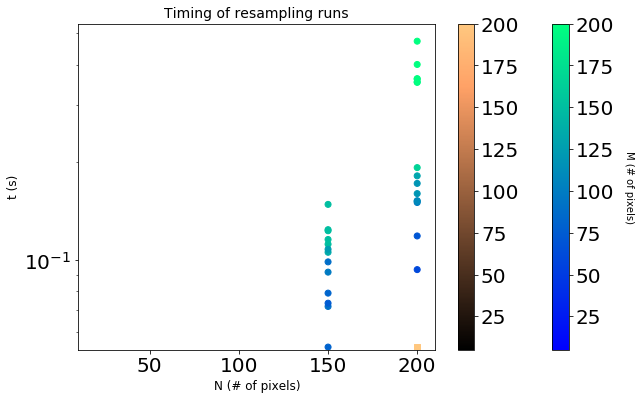

<Figure size 1080x1080 with 0 Axes>

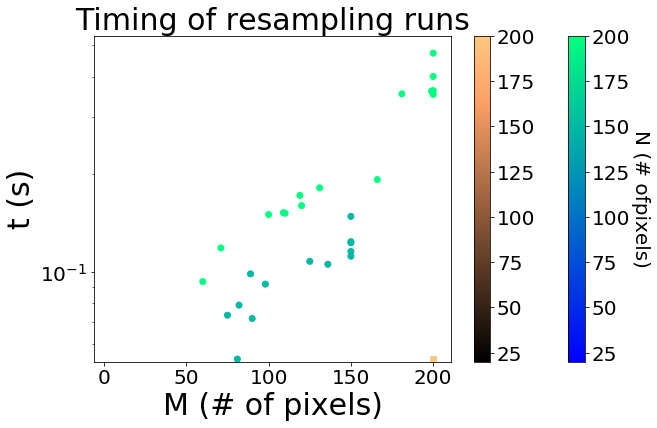

<Figure size 1080x1080 with 0 Axes>

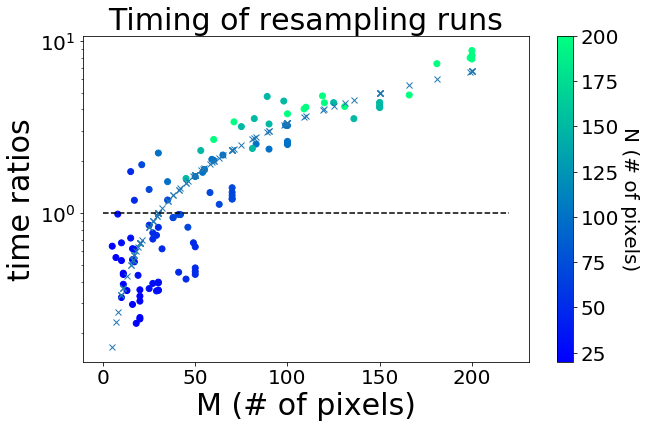

<Figure size 1080x1080 with 0 Axes>

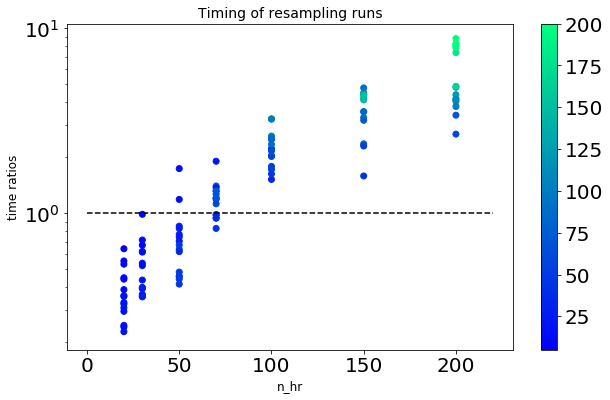

<Figure size 1080x1080 with 0 Axes>

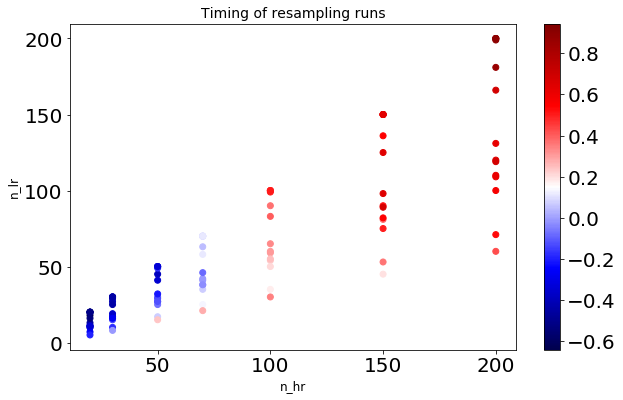

In [11]:
import pickle
afile = open('Timings_npsf='+str(npsf)+'.pkl', 'wb')
pickle.dump(structure, afile)
afile.close()

n_hrs = np.array(structure['n_hr'])
n_lrs = np.array(structure['n_lr'])
s_mean = (np.array(structure['s_mean']))
s_std = np.array(structure['s_std'])
g_mean = np.array(structure['g_mean'])
g_std = np.array(structure['g_std'])

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

figure(figsize = (15,15))
plt.subplots(figsize=(10, 6))
#ax2.errorbar(n_lrs, s_mean, yerr = s_std, capsize = 2, fmt = 'o', label = 'scarlet')
sc1 = scatter(n_hrs, s_mean,c = n_lrs, marker = 'o', cmap = 'winter')
#ax2.errorbar(n_lrs, g_mean, yerr = g_std, capsize = 2, fmt = 's', label = 'galsim')
sc2 = scatter(n_hrs, g_mean,c = n_lrs, marker = 's', cmap = 'copper')
yscale('log')
cbar = colorbar(sc1)
colorbar(sc2)
cbar.set_label('M (# of pixels)', rotation=270, labelpad = 20)
# Adding plotting parameters
title('Timing of resampling runs', fontsize=14)
xlabel('N (# of pixels)', fontsize=12)
ylabel('t (s)', fontsize=12)
show()

figure(figsize = (15,15))
plt.subplots(figsize=(10, 6))
#ax2.errorbar(n_lrs, s_mean, yerr = s_std, capsize = 2, fmt = 'o', label = 'scarlet')
sc1 = scatter(n_lrs, s_mean,c = n_hrs, marker = 'o', cmap = 'winter')
#ax2.errorbar(n_lrs, g_mean, yerr = g_std, capsize = 2, fmt = 's', label = 'galsim')
sc2 = scatter(n_lrs, g_mean,c = n_hrs, marker = 's', cmap = 'copper')
yscale('log')
cbar = colorbar(sc1)
colorbar(sc2)
cbar.set_label('N (# ofpixels)', rotation=270, fontsize = 20, labelpad = 20)
# Adding plotting parameters
title('Timing of resampling runs', fontsize=30)
xlabel('M (# of pixels)', fontsize=30)
ylabel('t (s)', fontsize=30)
savefig('galsim_scarlet_timing.png')
show()

figure(figsize = (15,15))
fig2, ax2 = plt.subplots(figsize=(10, 6))
sc1 = ax2.scatter(n_lrs, s_mean/g_mean,c = n_hrs, marker = 'o', cmap = 'winter')
plot(n_lrs, (n_lrs)/30, 'x')
yscale('log')
cbar = colorbar(sc1)
plot([0,220], [1,1], '--k')
cbar.set_label('N (# of pixels)', rotation=270, fontsize = 20, labelpad = 20)
# Adding plotting parameters
ax2.set_title('Timing of resampling runs', fontsize=30)
ax2.set_xlabel('M (# of pixels)', fontsize=30)
ax2.set_ylabel('time ratios', fontsize=30)
savefig('galsim_scarlet_ratio.png')
show()

figure(figsize = (15,15))
fig2, ax2 = plt.subplots(figsize=(10, 6))
sc1 = ax2.scatter(n_hrs, s_mean/g_mean,c = n_lrs, marker = 'o', cmap = 'winter')
yscale('log')
colorbar(sc1)
plot([0,220], [1,1], '--k')
# Adding plotting parameters
ax2.set_title('Timing of resampling runs', fontsize=14)
ax2.set_xlabel('n_hr', fontsize=12)
ax2.set_ylabel('time ratios', fontsize=12)
show()

figure(figsize = (15,15))
fig2, ax2 = plt.subplots(figsize=(10, 6))
sc1 = ax2.scatter(n_hrs, n_lrs,c = np.log10(s_mean/g_mean), marker = 'o', cmap = 'seismic')

colorbar(sc1)
# Adding plotting parameters
ax2.set_title('Timing of resampling runs', fontsize=14)
ax2.set_xlabel('n_hr', fontsize=12)
ax2.set_ylabel('n_lr', fontsize=12)
show()